#**1. IMPORTING LIBRARIES**

In [1]:
!pip install country_converter

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import country_converter as coco

import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
from PIL import Image
import requests

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.4 MB/s eta 0:00:00


# **2. EDA**


### **2.1 Extract information about the dataframes**


#### **2.1.1 Reading datasets**


In [2]:
url1="https://raw.githubusercontent.com/AvantikaJalote/Summer_Internship/main/PROJECT%201/Books.csv"
url2="https://raw.githubusercontent.com/AvantikaJalote/Summer_Internship/main/PROJECT%201/Ratings.csv"
url3="https://raw.githubusercontent.com/AvantikaJalote/Summer_Internship/main/PROJECT%201/Users.csv"

In [3]:
books=pd.read_csv(url1)
ratings=pd.read_csv(url2)
users=pd.read_csv(url3)

In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN



#### **2.1.2 Display the shape of the dataframes**

In [7]:
def shape_of_dataset(df, dataset_name="df"):
    
    print(f"{dataset_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    return df.shape[0], df.shape[1]

In [8]:
books_r, books_c = shape_of_dataset(books, "Books")
ratings_r, ratings_c = shape_of_dataset(ratings, "Ratings")
users_r, users_c = shape_of_dataset(users, "Users")

Books dataset has 271360 rows and 8 columns
Ratings dataset has 1149780 rows and 3 columns
Users dataset has 278858 rows and 3 columns



#### **2.1.3 Displaying the total number of null values in dataframes**

In [9]:
def count_null_values(df, dataset_name):
    
    num_of_total_null_values = sum(df.isnull().sum().values)
    print(f"{dataset_name} dataset has {num_of_total_null_values} null values")
    return num_of_total_null_values

In [10]:
books_null = count_null_values(books, "Books")
ratings_null = count_null_values(ratings, "Ratings")
users_null = count_null_values(users, "Users")

Books dataset has 6 null values
Ratings dataset has 0 null values
Users dataset has 110762 null values



#### **2.1.4 Detecting the null cols in the dataframes**

In [11]:
def detect_null_columns(df, dataset_name):
    
    col = []
    s = df.isnull().sum()
    for x in range(len(s)):
        if s[x] > 0:
            col.append(s.index[x])
    tot_cols = len(col)
    if tot_cols == 0:
        print(f"{dataset_name} dataset has no null columns")
        print("="*50)
    else:
        print(f"{dataset_name} dataset has {tot_cols} null columns and they are:")
        for x in col:
            print(x, end=',')
        print()
        print("="*50)
    return col, len(col)

In [12]:
total_books_null_cols, books_null_cols = detect_null_columns(books, "Books")
total_ratings_null_cols, ratings_null_cols = detect_null_columns(ratings, "Ratings")
total_users_null_cols, users_null_cols = detect_null_columns(users, "Users")

Books dataset has 3 null columns and they are:
Book-Author,Publisher,Image-URL-L,
Ratings dataset has no null columns
Users dataset has 1 null columns and they are:
Age,



#### **2.1.5 Creating the comparison dataframe**

In [13]:
detailed_db = pd.DataFrame({
    'dataset' : [],
    'nrows' : [],
    'ncols' :[],
    'null_amount' : [],
    'names_of_null_cols' : [],
    'num_null_cols' : []
})

In [14]:
def fill_db_dataset(dataset_name, nrows, ncols, null_amount, name_null_cols, num_null_cols):
    detailed_db.loc[len(detailed_db.index)] = [dataset_name, nrows, ncols, null_amount, ', '.join(name_null_cols), int(num_null_cols)]

In [15]:
fill_db_dataset('Books', books_r, books_c, books_null, total_books_null_cols, books_null_cols)
fill_db_dataset('Ratings', ratings_r, ratings_c, ratings_null, total_ratings_null_cols, ratings_null_cols)
fill_db_dataset('Users', users_r, users_c, users_null, total_users_null_cols, users_null_cols)

In [16]:
detailed_db

,dataset,nrows,ncols,null_amount,names_of_null_cols,num_null_cols
0,Books,271360,8,6,"Book-Author, Publisher, Image-URL-L",3
1,Ratings,1149780,3,0,,0
2,Users,278858,3,110762,Age,1



#### **2.1.6 Displaying information about dataframes**

In [17]:
def print_info_about_ds(df, name_of_the_ds = "df"):
    print(f"Info about the {name_of_the_ds} dataset: ")
    dash_sep()
    print(df.info())
    
def dash_sep(num=50):
    print("_"*num)

def double_fs_sep(num=40):
    print("**"*num)

In [18]:
print_info_about_ds(books, "Books")
print("\n")
double_fs_sep()
print("\n")

print_info_about_ds(ratings, "Ratings")
print("\n")
double_fs_sep()
print("\n")

print_info_about_ds(users, "Users")

Info about the Books dataset: 
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None


********************************************************************************


Info about the Ratings dataset: 
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns 


#### **2.1.7 Displaying the number of unique values in each column in the dataframes**

In [19]:
def print_nunique_vals(df, ds_name = 'df'):
    print(f"number of unique values in each column in the {ds_name} dataset:")
    dash_sep(75)
    print(df.nunique())

In [20]:
print_nunique_vals(books, 'Books')
print("\n")
double_fs_sep()
print("\n")

print_nunique_vals(ratings, 'Ratings')
print("\n")
double_fs_sep()
print("\n")

print_nunique_vals(users, 'Users')

number of unique values in each column in the Books dataset:
___________________________________________________________________________
ISBN                   271360
Book-Title             242135
Book-Author            102023
Year-Of-Publication       202
Publisher               16807
Image-URL-S            271044
Image-URL-M            271044
Image-URL-L            271041
dtype: int64


********************************************************************************


number of unique values in each column in the Ratings dataset:
___________________________________________________________________________
User-ID        105283
ISBN           340556
Book-Rating        11
dtype: int64


********************************************************************************


number of unique values in each column in the Users dataset:
___________________________________________________________________________
User-ID     278858
Location     57339
Age            165
dtype: int64



#### **2.1.8 Ploting the distrbution of Missing values in the dataframes**

In [21]:
def plot_miss_vals(df, ds_name):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()

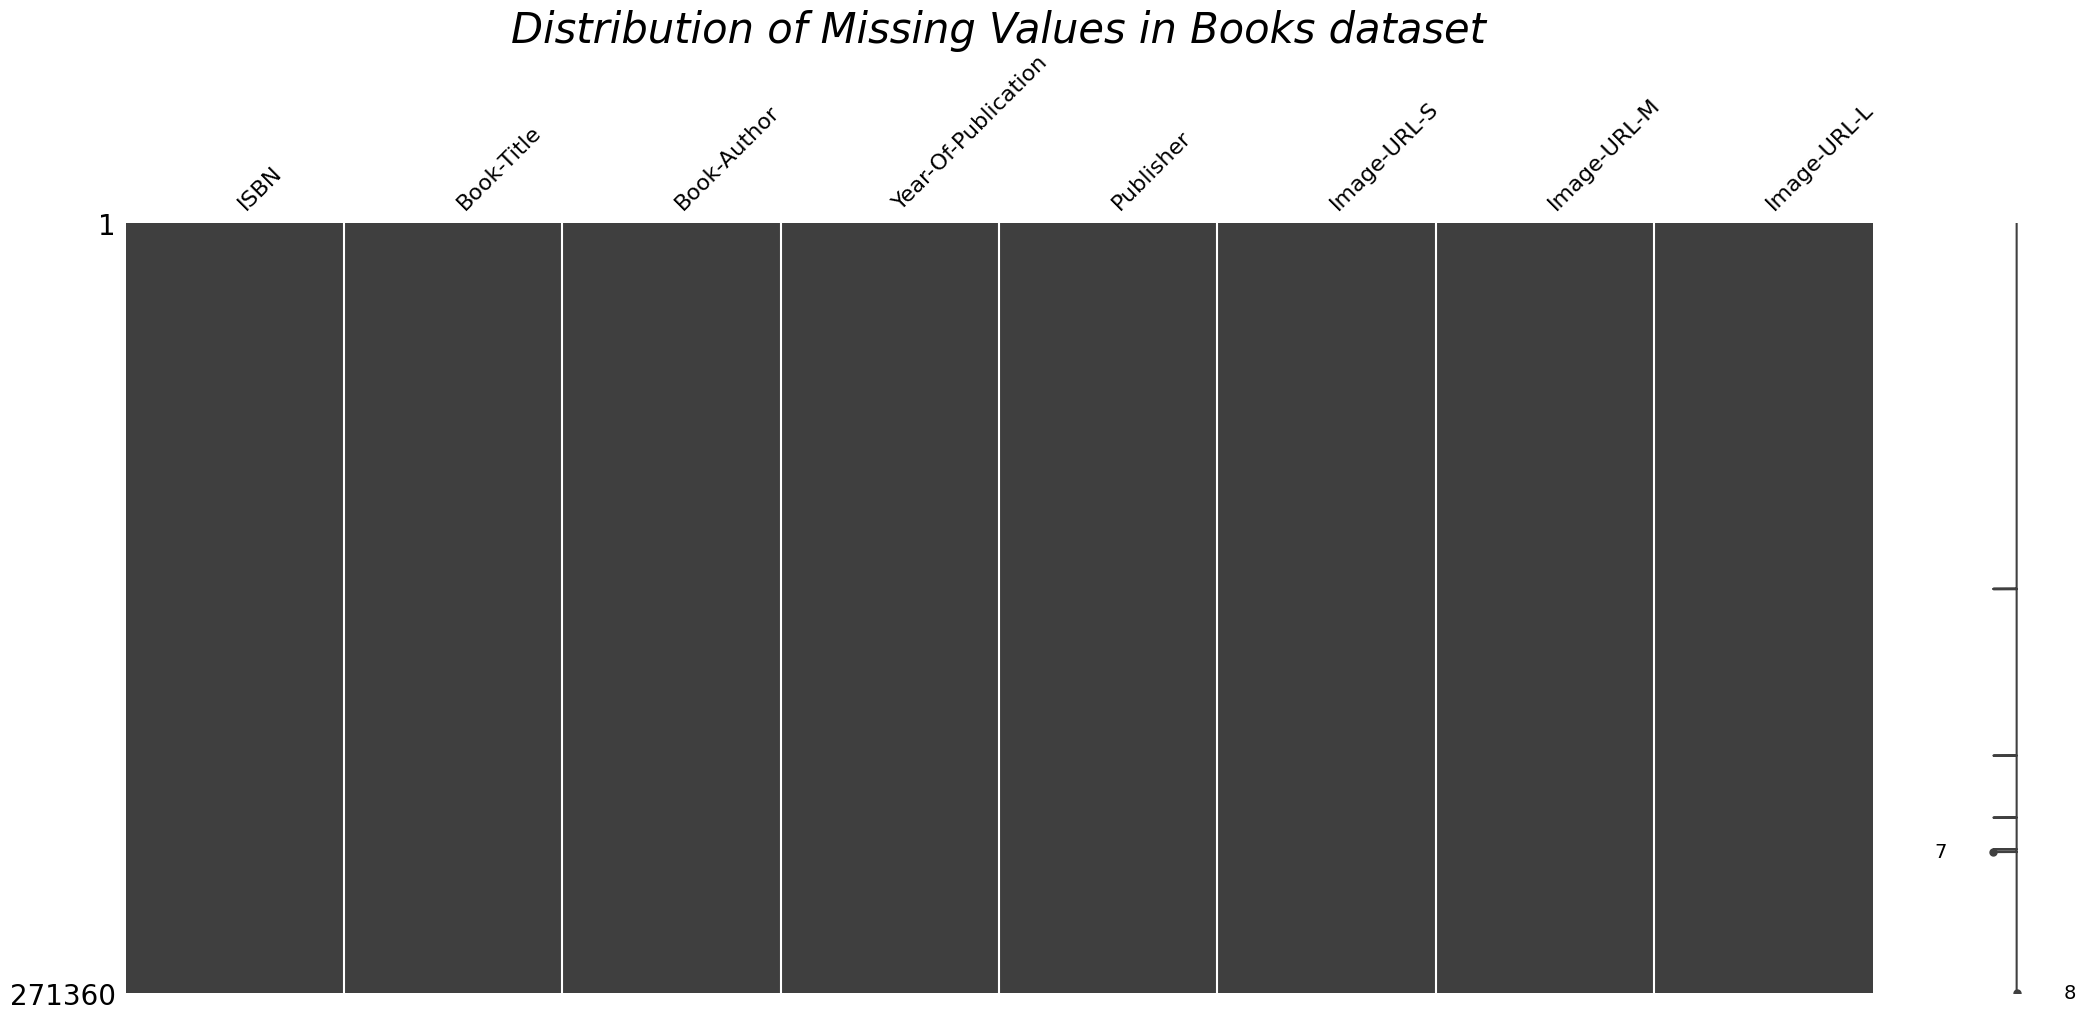

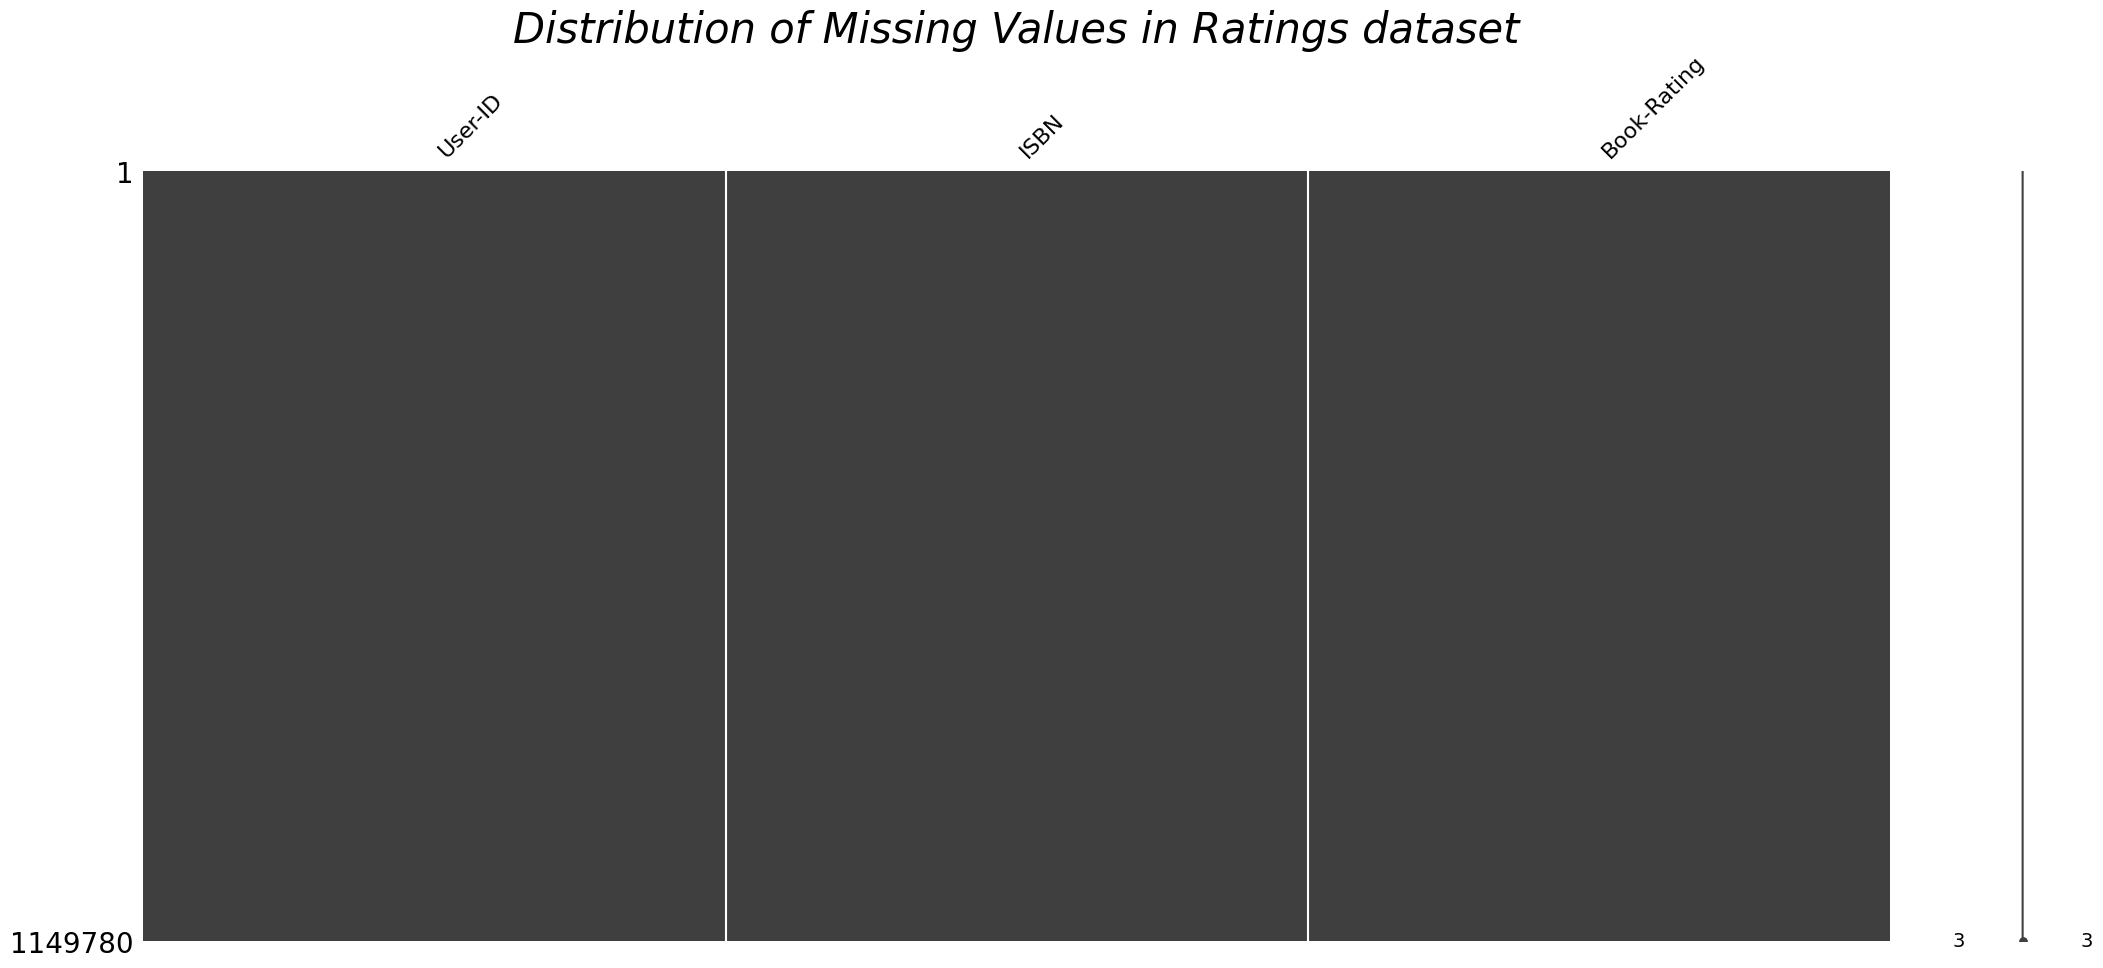

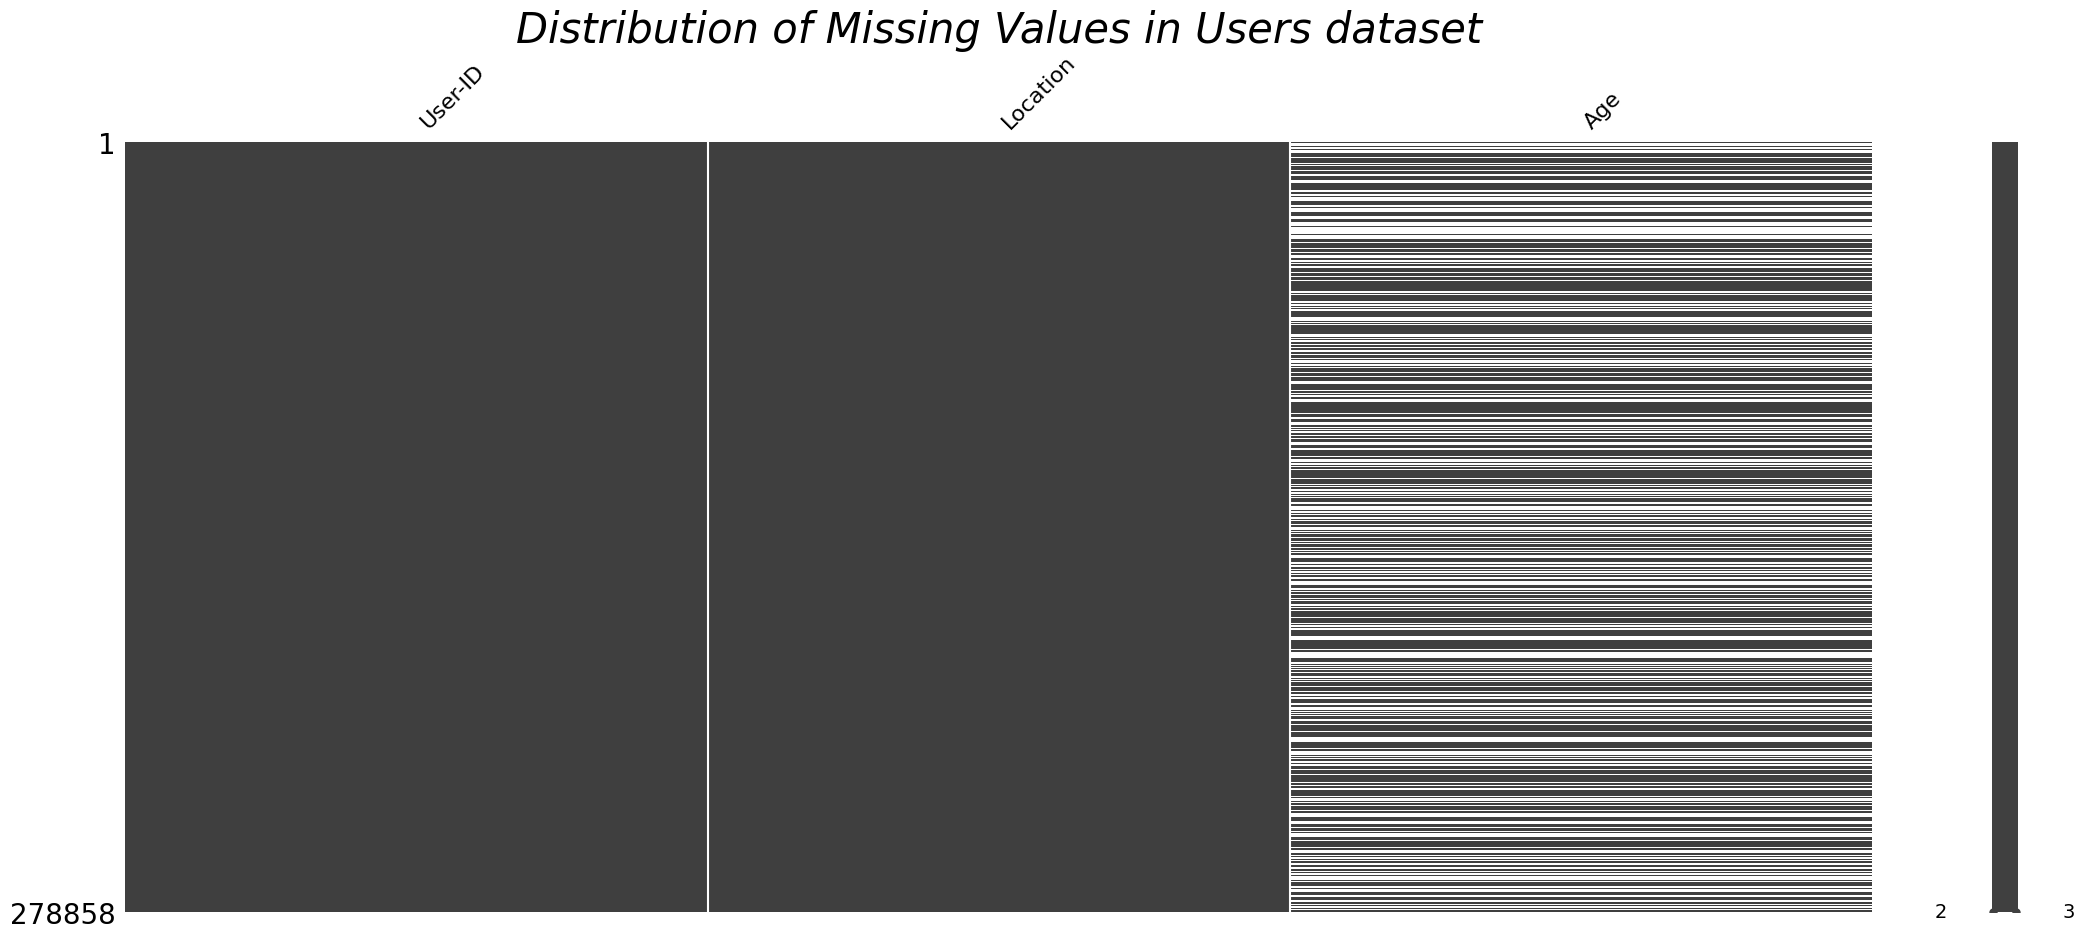

In [22]:
plot_miss_vals(books, "Books")
plot_miss_vals(ratings, "Ratings")
plot_miss_vals(users, "Users")


#### **2.1.9 Displaying the data types of the dataframes**

In [23]:
def print_dtype_of_df(df, ds_name = 'df'):
    print(f"data type of each column in the {ds_name} dataset:")
    dash_sep(75)
    print(df.dtypes)

In [24]:
print_dtype_of_df(books, 'Books')
double_fs_sep()

print_dtype_of_df(ratings, 'Ratings')
double_fs_sep()

print_dtype_of_df(users, 'Users')

data type of each column in the Books dataset:
___________________________________________________________________________
ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object
********************************************************************************
data type of each column in the Ratings dataset:
___________________________________________________________________________
User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object
********************************************************************************
data type of each column in the Users dataset:
___________________________________________________________________________
User-ID       int64
Location     object
Age         float64
dtype: object



### **2.2 Visualizaation and Preprocessing**

In [25]:
def plot_top20(df, column, title, x_label, y_label, top=20, template = 'plotly_dark'):
    
    pl = df[column].value_counts().head(top)
    fig = px.bar(y=pl.values, 
                 x=pl.index, 
                 color_discrete_sequence=px.colors.sequential.PuBuGn,
                 text=pl.values,
                 title= title,
                 template= template)
    fig.update_layout(
        xaxis_title=x_label,
        yaxis_title=y_label,
        font = dict(size=15,family="Franklin Gothic"))
    fig.show()

We will see top years in which books were published

There is an error in the Year Of Publication column when converting its data type to int

In [26]:
books['Year-Of-Publication'].astype('int32')

ValueError: ignored

In the year of publication column there is an error in which the column contains string value 'DK Publishing Inc' and that is a data entry error. A year column has all integers.

In [27]:
books[(books['Year-Of-Publication'] == 'DK Publishing Inc') | (books['Year-Of-Publication'] == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In these 2 rows, the value of the year is value in Book author, and the value of Year of Publication should be in the publisher, so, values need to be shifted

In [28]:
temp = books[(books['Year-Of-Publication'] == 'DK Publishing Inc') | (books['Year-Of-Publication'] == 'Gallimard')]

In [29]:
temp[temp['Book-Author'] == temp['Book-Author'][209538]]['Book-Title'].values[0]

'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\\";Michael Teitelbaum"'

In [30]:
temp[temp['Book-Author'] == temp['Book-Author'][209538]]['Book-Title'].values[1]

'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\\";James Buckley"'

The name of the authors are concatenated with the Book title so we need to seperate them

In [31]:
authors = []
books_titles = []

for title in temp['Book-Title']:
    
    author = title.split(';')[-1].split('"')[0]
    book = title.split(';')[0].split('\\')[0]

    authors.append(author)
    books_titles.append(book)

In [32]:
authors

['Michael Teitelbaum', 'Jean-Marie Gustave Le ClÃ?Â©zio', 'James Buckley']

In [33]:
books_titles

['DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)',
 "Peuple du ciel, suivi de 'Les Bergers",
 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)']

Now we have separated the book titles and the authors, let's shift the values and assign the new ones

In [34]:
cols_to_shift = books.columns[1:]
cols_to_shift

Index(['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [35]:
temp = pd.concat([temp['ISBN'].to_frame(), temp[cols_to_shift].shift(periods = 1, axis = 1)], axis=1)
temp

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,None,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,None,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,None,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...


Shifted the value, assigning the new ones.

In [36]:
temp['Book-Title'] = books_titles
temp['Book-Author'] = authors

In [37]:
temp

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...


Assigning the new rows to the original books data

In [38]:
rows_to_rem = list(temp.index)
rows_to_rem

[209538, 220731, 221678]

In [39]:
books.shape

(271360, 8)

In [40]:
books.drop(rows_to_rem, axis=0, inplace=True)

In [41]:
books.shape

(271357, 8)

Removed the dirty rows, adding the new cleaned ones

In [42]:
for ind in rows_to_rem:
    
    books.loc[ind] = list(temp.loc[ind].values)

In [43]:
books.shape

(271360, 8)

In [44]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype('int32')

In [45]:
books.dtypes

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int32
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object

The year column had been fixed

In [46]:
plot_top20(books, 'Year-Of-Publication', 'Top 20 years in which books were published in terms of count', "Year", "Count")

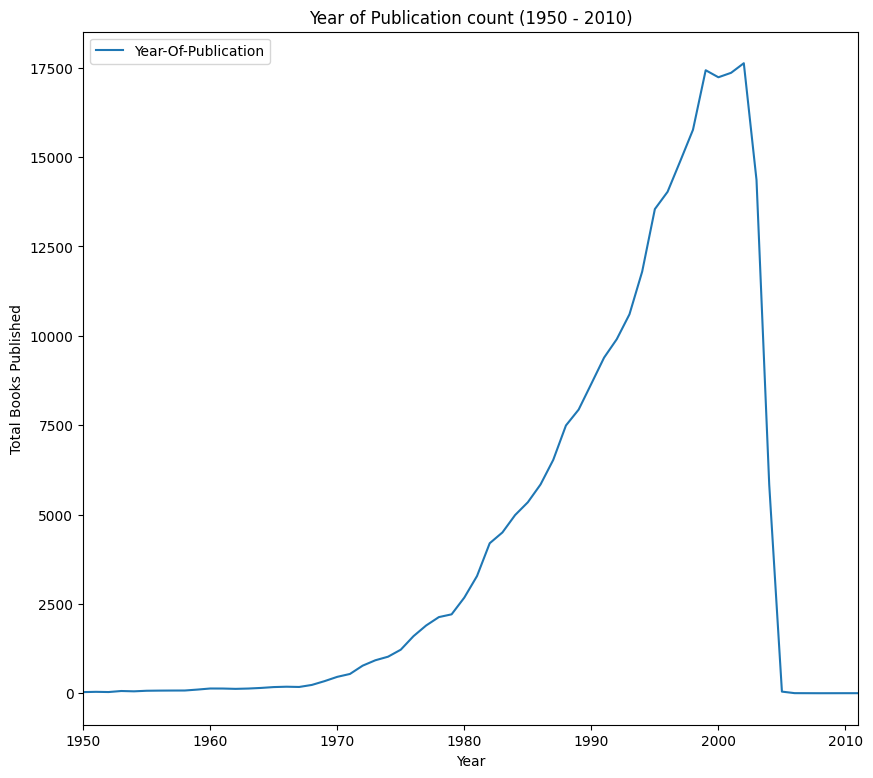

In [47]:
year_count=books['Year-Of-Publication'].value_counts()
year_count=pd.DataFrame(year_count)

plt.figure(figsize=(10, 9))
sns.lineplot(data=year_count)
plt.title('Year of Publication count (1950 - 2010)')
plt.xlim(1950, 2011)
plt.xlabel('Year')
plt.ylabel('Total Books Published')
plt.show()

The years 1999-2002 are the years in which most books were published.

Top 20 authors with books in this data:

In [48]:
plot_top20(books, 'Book-Author', "Top 20 Authors authored books by count", "Author name", "Count")

Agatha Christie is the top author with 632 books in the dataset

Top 20 Publishers who have publisbed books in this data:

In [49]:
plot_top20(books, 'Publisher', "Top 20 Publishers who have published books", "Publisher name", "Count")

Merging books with ratings

In [50]:
books_with_ratings = pd.merge(books, ratings, on='ISBN')

In [51]:
books_with_ratings.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0


In [52]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=10),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)

In [53]:
colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

In [54]:
cat_summary_with_graph(books_with_ratings, 'Book-Rating')

Average rating of the books of the top 20 authors:

Top 20 authors in the data:

In [55]:
authors_top20 = books['Book-Author'].value_counts().head(20)
authors_top20 = list(authors_top20.index)

Droping the null values

In [56]:
books_with_ratings.dropna(inplace=True)

In [57]:
top20_authors = pd.DataFrame(columns = books_with_ratings.columns)

for author in authors_top20:
    
    cond_df = books_with_ratings[books_with_ratings['Book-Author'] == author]
    
    top20_authors =  pd.concat([top20_authors, cond_df], axis=0)
    
    

In [58]:
top20_authors.shape

(45234, 10)

There is no 0 rating, ratings is from 1-10 scale, then 0 means the book is not rated that it is not rated. So, excluding the zero rating.

In [59]:
top20_author = top20_authors[top20_authors['Book-Rating'] != 0]

In [60]:
top20_author.shape

(16871, 10)

Mean rating of all the 20 authors:

In [61]:
top20_author = top20_author.groupby('Book-Author')['Book-Rating'].agg('mean').reset_index().sort_values(by='Book-Rating', ascending=False)
top20_author

,Book-Author,Book-Rating
19,William Shakespeare,8.303357
11,Mark Twain,8.284507
8,Jane Austen,8.187595
18,Terry Pratchett,8.151177
14,Not Applicable (Na ),8.094340
7,Isaac Asimov,7.915167
3,Carolyn Keene,7.823529
17,Stephen King,7.815046
0,Agatha Christie,7.792102
4,Charles Dickens,7.762836


In [62]:
fig = px.bar(y=top20_author['Book-Rating'], 
             x=top20_author['Book-Author'], 
             color_discrete_sequence=px.colors.sequential.PuBuGn,
             text=round(top20_author['Book-Rating'],2),
             title= "Average ratings of the books of the Top 20 authors",
             template= 'plotly_dark')
fig.update_layout(
    xaxis_title="author name",
    yaxis_title="average rating",
    font = dict(size=15,family="Franklin Gothic"))
fig.show()

William Shakespeare is the top rated author

Average rating of the books of the top 20 publishers:

In [63]:
publishers_top20 = books['Publisher'].value_counts().head(20)
publishers_top20 = list(publishers_top20.index)

top20_publishers = pd.DataFrame(columns = books_with_ratings.columns)

for pub in publishers_top20:
    
    cond_df = books_with_ratings[books_with_ratings['Publisher'] == pub]
    
    top20_publishers =  pd.concat([top20_publishers, cond_df], axis=0)
    
    
top20_publishers = top20_publishers[top20_publishers['Book-Rating'] != 0]
top20_publishers = top20_publishers.groupby('Publisher')['Book-Rating'].agg('mean').reset_index().sort_values(by='Book-Rating', ascending=False)

top20_publishers

,Publisher,Book-Rating
11,Scholastic,7.818161
7,Penguin Books,7.773789
17,Tor Books,7.686075
0,Ballantine Books,7.610437
16,St. Martin's Press,7.596059
12,Signet Book,7.591292
5,HarperCollins Publishers,7.584115
9,Pocket,7.564115
18,Warner Books,7.543623
14,Simon &amp; Schuster,7.522894


In [64]:
fig = px.bar(y=top20_publishers['Book-Rating'], 
             x=top20_publishers['Publisher'], 
             color_discrete_sequence=px.colors.sequential.PuBuGn,
             text=round(top20_publishers['Book-Rating'],2),
             title= "Average ratings of the books of the Top 20 Publishers",
             template= 'plotly_dark')
fig.update_layout(
    xaxis_title="Publisher name",
    yaxis_title="average rating",
    font = dict(size=15,family="Franklin Gothic"))
fig.show()

The average rating of the books of the publishers are close to each other

Most rated books by users

In [65]:
df = pd.merge(books_with_ratings, users, on='User-ID')
df = books_with_ratings[books_with_ratings['Book-Rating'] != 0]
plot_top20(df, 'Book-Title', "Most Rated Books by Users", "Book Title", "Number of ratings")

Top rated books:

In [66]:
books_top20 = df['Book-Title'].value_counts().head(20)
books_top20 = list(books_top20.index)

top20_books = pd.DataFrame(columns = books_with_ratings.columns)

for book in books_top20:
    
    cond_df = books_with_ratings[books_with_ratings['Book-Title'] == book]
    
    top20_books =  pd.concat([top20_books, cond_df], axis=0)
    
    
top20_books = top20_books[top20_books['Book-Rating'] != 0]
top20_books = top20_books.groupby('Book-Title')['Book-Rating'].agg('mean').reset_index().sort_values(by='Book-Rating', ascending=False)

top10_books = top20_books.head(10)
top10_books

,Book-Title,Book-Rating
6,Harry Potter and the Prisoner of Azkaban (Book 3),9.043321
7,Harry Potter and the Sorcerer's Stone (Harry P...,8.936508
5,Harry Potter and the Chamber of Secrets (Book 2),8.840491
16,The Secret Life of Bees,8.477833
10,The Da Vinci Code,8.439271
11,The Lovely Bones: A Novel,8.185290
15,The Red Tent (Bestselling Backlist),8.182768
18,Where the Heart Is (Oprah's Book Club (Paperba...,8.142373
8,Life of Pi,8.080357
1,Angels &amp; Demons,8.016129


In [67]:
fig = px.bar(y=top10_books['Book-Rating'], 
             x=top10_books['Book-Title'], 
             color_discrete_sequence=px.colors.sequential.PuBuGn,
             text=round(top10_books['Book-Rating'],2),
             title= "Top 10 rated books by the users",
             template= 'plotly_dark')
fig.update_layout(
    xaxis_title="Book title",
    yaxis_title="average rating",
    font = dict(size=15,family="Franklin Gothic"))
fig.show()

Harry Potter are the most rated books


# **3. Most Popular Books recommendation**

In [68]:
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk))
def prRed(skk): print("\033[91m {}\033[00m" .format(skk))
def prYellow(skk): print("\033[93m {}\033[00m" .format(skk))

    
def popular_books():
    
    for (book, ratings) in zip(top10_books['Book-Title'], top10_books['Book-Rating']):
        prGreen(book)
        print("Rating",end='->')
        prRed(round(ratings,1))
        print("-"*50)
        
popular_books()

 Harry Potter and the Prisoner of Azkaban (Book 3)
Rating-> 9.0
--------------------------------------------------
 Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Rating-> 8.9
--------------------------------------------------
 Harry Potter and the Chamber of Secrets (Book 2)
Rating-> 8.8
--------------------------------------------------
 The Secret Life of Bees
Rating-> 8.5
--------------------------------------------------
 The Da Vinci Code
Rating-> 8.4
--------------------------------------------------
 The Lovely Bones: A Novel
Rating-> 8.2
--------------------------------------------------
 The Red Tent (Bestselling Backlist)
Rating-> 8.2
--------------------------------------------------
 Where the Heart Is (Oprah's Book Club (Paperback))
Rating-> 8.1
--------------------------------------------------
 Life of Pi
Rating-> 8.1
--------------------------------------------------
 Angels &amp; Demons
Rating-> 8.0
--------------------------------------------------



# **4. Collaborative Filtering**

Collaborative Filtering is a technique or a method to predict a user’s taste and find the items that a user might prefer on the basis of information collected from various other users having similar tastes or preferences. It takes into consideration the basic fact that if person X and person Y have a certain reaction for some items then they might have the same opinion for other items too. 

The two most popular forms of collaborative filtering are:

User Based: Here, we look for the users who have rated various items in the same way and then find the rating of the missing item with the help of these users.<br><br>
Item Based: Here, we explore the relationship between the pair of items (the user who bought Y, also bought Z). We find the missing rating with the help of the ratings given to the other items by the user.


### **4.1 Item Based Collaborative Filtering**

Counting the rating books to classify the common and rare oneS

In [69]:
count_rate = pd.DataFrame(df['Book-Title'].value_counts())
count_rate.head()

,Book-Title
The Lovely Bones: A Novel,707
Wild Animus,581
The Da Vinci Code,494
The Secret Life of Bees,406
The Nanny Diaries: A Novel,393


Classifying the rare books as the books that got rated 100 or less times

In [70]:
rare_books=count_rate[count_rate["Book-Title"]<=100].index
rare_books[:5]

Index(['Don't Sweat the Small Stuff and It's All Small Stuff : Simple Ways to Keep the Little Things from Taking Over Your Life (Don't Sweat the Small Stuff Series)',
       'Daddy's Little Girl', 'Disclosure',
       'The Queen of the Damned (Vampire Chronicles (Paperback))',
       'Cause of Death'],
      dtype='object')

In [71]:
len(rare_books)

135373

If the book is not included in the rare books then classify it as common one

In [72]:
common_books=df[~df["Book-Title"].isin(rare_books)]
common_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
31,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,11676,9
32,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,29526,9
34,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,46398,9
36,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,49635,9
37,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,67958,10


In [73]:
common_books.shape

(33641, 10)

Making recommendation if the book is common

Creating dataframe where index is the Users IDs and the columns are the books titles and the values are the rating of the user to that book

In [74]:
item_based_cb = common_books.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")

Assuming a book title and see what recommendations can be made

Creating recommendation df with the corrwith function

In [75]:
book_title = 'Me Talk Pretty One Day'
sim = item_based_cb[book_title]
recommendation_df=pd.DataFrame(item_based_cb.corrwith(sim).sort_values(ascending=False)).reset_index(drop=False)
recommendation_df

,Book-Title,0
0,Me Talk Pretty One Day,1.0
1,Left Behind: A Novel of the Earth's Last Days ...,1.0
2,"A Child Called \It\"": One Child's Courage to S...",1.0
3,Lord of the Flies,1.0
4,The Chamber,1.0
...,...,...
187,The Rescue,NaN
188,"The Return of the King (The Lord of the Rings,...",NaN
189,The Smoke Jumper,NaN
190,When the Wind Blows,NaN


Checking if the book the user choosen is included in the recommendation df or not, because if it is included, we don't want to recommend it so we will  drop it

In [76]:
if not recommendation_df['Book-Title'][recommendation_df['Book-Title'] == book_title].empty:
    recommendation_df=recommendation_df.drop(recommendation_df[recommendation_df["Book-Title"]==book_title].index[0])

Collect the books with less ratings (average rating is less than 5)

In [77]:
less_rating=[]
for i in recommendation_df["Book-Title"]:
    if df[df["Book-Title"]==i]["Book-Rating"].mean() < 5:
        less_rating.append(i)
        
less_rating

['Wild Animus']

Rank the highly rated books

In [78]:
if recommendation_df.shape[0] - len(less_rating) > 5:
    
    recommendation_df=recommendation_df[~recommendation_df["Book-Title"].isin(less_rating)]            
    recommendation_df.columns=["Book-Title","Correlation"]
    
    
for (candidate_book, corr) in zip(recommendation_df['Book-Title'], recommendation_df['Correlation']):
    corr_thershold = 0.7
    if corr > corr_thershold:
        ratings = df[df['Book-Title'] == candidate_book]['Book-Rating'].mean()
        prGreen(candidate_book)
        print("Rating ", end = '->')
        prRed(round(ratings,1))
        print("-"*50)
    else:
        break

 Left Behind: A Novel of the Earth's Last Days (Left Behind No. 1)
Rating -> 7.7
--------------------------------------------------
 A Child Called \It\": One Child's Courage to Survive"
Rating -> 8.0
--------------------------------------------------
 Lord of the Flies
Rating -> 8.0
--------------------------------------------------
 The Chamber
Rating -> 7.4
--------------------------------------------------
 The Poisonwood Bible: A Novel
Rating -> 8.2
--------------------------------------------------
 The Lost World
Rating -> 7.2
--------------------------------------------------
 Four Blind Mice
Rating -> 8.2
--------------------------------------------------
 It
Rating -> 8.1
--------------------------------------------------
 She's Come Undone (Oprah's Book Club)
Rating -> 7.7
--------------------------------------------------
 While I Was Gone
Rating -> 7.0
--------------------------------------------------
 The Reader
Rating -> 7.2
---------------------------------------------

Item based collaborative recommendation system is ready, let's put it all together to build our Recommendation System

In [79]:
def item_based_coll_rs(book_title):
    
    book_title = str(book_title)
    if book_title in books_with_ratings['Book-Title'].values:
        
        count_rate = pd.DataFrame(df['Book-Title'].value_counts())
        rare_books=count_rate[count_rate["Book-Title"]<=100].index
        
        common_books=df[~df["Book-Title"].isin(rare_books)]

        if book_title in rare_books:
            prYellow("A rare book, so u may try our popular books: \n ")
            popular_books()
            
        else:
            
            item_based_cb = common_books.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
            sim = item_based_cb[book_title]
            recommendation_df=pd.DataFrame(item_based_cb.corrwith(sim).sort_values(ascending=False)).reset_index(drop=False)

            if not recommendation_df['Book-Title'][recommendation_df['Book-Title'] == book_title].empty:
                recommendation_df=recommendation_df.drop(recommendation_df[recommendation_df["Book-Title"]==book_title].index[0])

            less_rating=[]
            for i in recommendation_df["Book-Title"]:
                if df[df["Book-Title"]==i]["Book-Rating"].mean() < 5:
                    less_rating.append(i)

            if recommendation_df.shape[0] - len(less_rating) > 5:

                recommendation_df=recommendation_df[~recommendation_df["Book-Title"].isin(less_rating)]            
                recommendation_df.columns=["Book-Title","Correlation"]


            for (candidate_book, corr) in zip(recommendation_df['Book-Title'], recommendation_df['Correlation']):
                corr_thershold = 0.7
                if corr > corr_thershold:
                    ratings = df[df['Book-Title'] == candidate_book]['Book-Rating'].mean()
                    prGreen(candidate_book)
                    print("Rating ", end = '->')
                    prRed(round(ratings,1))
                    print("-"*50)
                else:
                    break
                
    else:
        prYellow("This book is not in our library, check out our most popular books:")
        print()
        popular_books()

In [80]:
item_based_coll_rs('Me Talk Pretty One Day')

 Left Behind: A Novel of the Earth's Last Days (Left Behind No. 1)
Rating -> 7.7
--------------------------------------------------
 A Child Called \It\": One Child's Courage to Survive"
Rating -> 8.0
--------------------------------------------------
 Lord of the Flies
Rating -> 8.0
--------------------------------------------------
 The Chamber
Rating -> 7.4
--------------------------------------------------
 The Poisonwood Bible: A Novel
Rating -> 8.2
--------------------------------------------------
 The Lost World
Rating -> 7.2
--------------------------------------------------
 Four Blind Mice
Rating -> 8.2
--------------------------------------------------
 It
Rating -> 8.1
--------------------------------------------------
 She's Come Undone (Oprah's Book Club)
Rating -> 7.7
--------------------------------------------------
 While I Was Gone
Rating -> 7.0
--------------------------------------------------
 The Reader
Rating -> 7.2
---------------------------------------------

In [81]:
item_based_coll_rs("The Da Vinci Code")

 Silence of the Lambs
Rating -> 8.4
--------------------------------------------------
 Dance upon the Air (Three Sisters Island Trilogy)
Rating -> 8.0
--------------------------------------------------
 Unnatural Exposure
Rating -> 7.8
--------------------------------------------------
 The Divine Secrets of the Ya-Ya Sisterhood: A Novel
Rating -> 7.8
--------------------------------------------------
 The Smoke Jumper
Rating -> 7.4
--------------------------------------------------
 Four Blind Mice
Rating -> 8.2
--------------------------------------------------
 Back Roads
Rating -> 7.3
--------------------------------------------------
 Girl, Interrupted
Rating -> 7.3
--------------------------------------------------
 The Hitchhiker's Guide to the Galaxy
Rating -> 8.5
--------------------------------------------------
 Pop Goes the Weasel
Rating -> 7.5
--------------------------------------------------
 A Map of the World
Rating -> 7.0
---------------------------------------------

In [82]:
item_based_coll_rs("The Alchemist: A Fable About Following Your Dream")

 The Subtle Knife (His Dark Materials, Book 2)
Rating -> 8.7
--------------------------------------------------
 The Rescue
Rating -> 7.6
--------------------------------------------------
 The King of Torts
Rating -> 7.5
--------------------------------------------------
 The Pelican Brief
Rating -> 7.7
--------------------------------------------------
 Two for the Dough
Rating -> 8.3
--------------------------------------------------
 A Heartbreaking Work of Staggering Genius
Rating -> 7.2
--------------------------------------------------
 A Is for Alibi (Kinsey Millhone Mysteries (Paperback))
Rating -> 7.6
--------------------------------------------------
 Harry Potter and the Chamber of Secrets (Book 2)
Rating -> 8.8
--------------------------------------------------
 I Know This Much Is True
Rating -> 8.3
--------------------------------------------------
 The Tao of Pooh
Rating -> 8.0
--------------------------------------------------
 Back Roads
Rating -> 7.3
----------------

In [83]:
item_based_coll_rs("The Hitchhiker's Guide to the Galaxy")

 Black House
Rating -> 7.6
--------------------------------------------------
 Violets Are Blue
Rating -> 7.6
--------------------------------------------------
 STONES FROM THE RIVER
Rating -> 8.0
--------------------------------------------------
 The Client
Rating -> 7.9
--------------------------------------------------
 Pop Goes the Weasel
Rating -> 7.5
--------------------------------------------------
 A Heartbreaking Work of Staggering Genius
Rating -> 7.2
--------------------------------------------------
 The Pilot's Wife : A Novel
Rating -> 7.5
--------------------------------------------------
 The Smoke Jumper
Rating -> 7.4
--------------------------------------------------
 2nd Chance
Rating -> 7.8
--------------------------------------------------
 The Bridges of Madison County
Rating -> 7.5
--------------------------------------------------
 I Know This Much Is True
Rating -> 8.3
--------------------------------------------------
 The Cider House Rules
Rating -> 7.8
---

In [84]:
item_based_coll_rs("The Subtle Art of Not Giving a F*ck")

 This book is not in our library, check out our most popular books:

 Harry Potter and the Prisoner of Azkaban (Book 3)
Rating-> 9.0
--------------------------------------------------
 Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Rating-> 8.9
--------------------------------------------------
 Harry Potter and the Chamber of Secrets (Book 2)
Rating-> 8.8
--------------------------------------------------
 The Secret Life of Bees
Rating-> 8.5
--------------------------------------------------
 The Da Vinci Code
Rating-> 8.4
--------------------------------------------------
 The Lovely Bones: A Novel
Rating-> 8.2
--------------------------------------------------
 The Red Tent (Bestselling Backlist)
Rating-> 8.2
--------------------------------------------------
 Where the Heart Is (Oprah's Book Club (Paperback))
Rating-> 8.1
--------------------------------------------------
 Life of Pi
Rating-> 8.1
--------------------------------------------------
 Angels &amp; De

In [85]:
item_based_coll_rs("Tuesdays with Morrie An Old Man a Young Man and Life s Greatest Lesson")


 This book is not in our library, check out our most popular books:

 Harry Potter and the Prisoner of Azkaban (Book 3)
Rating-> 9.0
--------------------------------------------------
 Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Rating-> 8.9
--------------------------------------------------
 Harry Potter and the Chamber of Secrets (Book 2)
Rating-> 8.8
--------------------------------------------------
 The Secret Life of Bees
Rating-> 8.5
--------------------------------------------------
 The Da Vinci Code
Rating-> 8.4
--------------------------------------------------
 The Lovely Bones: A Novel
Rating-> 8.2
--------------------------------------------------
 The Red Tent (Bestselling Backlist)
Rating-> 8.2
--------------------------------------------------
 Where the Heart Is (Oprah's Book Club (Paperback))
Rating-> 8.1
--------------------------------------------------
 Life of Pi
Rating-> 8.1
--------------------------------------------------
 Angels &amp; De


### **4.2 User Based Collaborative Filtering**

Return the active users who have presented in the dataset more than 100 times

In [86]:
new_df=df[df['User-ID'].map(df['User-ID'].value_counts()) > 100] 

In [87]:
new_df.shape

(102369, 10)

Make the matrix, User as indices, Books as columns and finally ratings as values

In [88]:
users_matrix=new_df.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
users_matrix.head()

Book-Title,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",Dark Justice,Final Fantasy Anthology: Official Strategy Guide (Brady Games),"Good Wives: Image and Reality in the Lives of Women in Northern New England, 1650-1750",Highland Desire (Zebra Splendor Historical Romances),"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",Murder of a Sleeping Beauty (Scumble River Mysteries (Paperback)),Nonbook Materials: The Organization of Integrated Collections,"Q-Space (Star Trek The Next Generation, Book 47)","Q-Zone (Star Trek The Next Generation, Book 48)",...,termcap &amp; terminfo (O'Reilly Nutshell),the Dark Light Years,them (Modern Library),together by christmas,"wet sand, raven tracks",whataboutrick.com: a poetic tribute to Richard A. Ricci,"Â¡Corre, perro, corre!",Â¿Eres tu mi mamÃ¡?/Are You My Mother?,Ã?ngeles fugaces (Falling Angels),Ã?Â?ber das Fernsehen.
User-ID,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Return user's favorite books

In [89]:
user_id = 2033 # we assume we want to recommend for that user
users_fav=new_df[new_df["User-ID"]==user_id].sort_values(["Book-Rating"],ascending=False)[0:5]
users_fav.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
66420,0142000663,The Grapes of Wrath: John Steinbeck Centennial...,John Steinbeck,2002,Penguin Books,http://images.amazon.com/images/P/0142000663.0...,http://images.amazon.com/images/P/0142000663.0...,http://images.amazon.com/images/P/0142000663.0...,2033,10
345591,0451458990,Shadows and Light,Anne Bishop,2002,Roc,http://images.amazon.com/images/P/0451458990.0...,http://images.amazon.com/images/P/0451458990.0...,http://images.amazon.com/images/P/0451458990.0...,2033,10
345438,0812523679,Monkey Sonatas,Orson Scott Card,1993,Tor Books (Mm),http://images.amazon.com/images/P/0812523679.0...,http://images.amazon.com/images/P/0812523679.0...,http://images.amazon.com/images/P/0812523679.0...,2033,10
212216,0345340426,The Hobbit and The Lord of the Rings,J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345340426.0...,http://images.amazon.com/images/P/0345340426.0...,http://images.amazon.com/images/P/0345340426.0...,2033,10
345576,0451458028,The Invisible Ring,Anne Bishop,2000,Roc,http://images.amazon.com/images/P/0451458028.0...,http://images.amazon.com/images/P/0451458028.0...,http://images.amazon.com/images/P/0451458028.0...,2033,10


In [90]:
index=np.where(users_matrix.index==2033)[0][0]
index

0

Calculate the similarity between the active user and other users

In [91]:
users_matrix.fillna(0, inplace=True)

Replacing nan values with zero to calculate the similarity

In [92]:
similarity=cosine_similarity(users_matrix)
similarity[0]

array([1.        , 0.        , 0.04900176, 0.        , 0.        ,
       0.        , 0.        , 0.03936096, 0.        , 0.        ,
       0.00801549, 0.01072026, 0.        , 0.00836158, 0.01598899,
       0.        , 0.05059689, 0.01450614, 0.        , 0.01363636,
       0.01792129, 0.        , 0.00409943, 0.01468785, 0.        ,
       0.        , 0.        , 0.00349717, 0.0060283 , 0.01120746,
       0.00835357, 0.        , 0.01631097, 0.        , 0.02289906,
       0.00300746, 0.01415305, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01613501, 0.        ,
       0.        , 0.02571924, 0.04847224, 0.        , 0.        ,
       0.        , 0.00806266, 0.010087  , 0.        , 0.01805005,
       0.        , 0.00460807, 0.        , 0.01787316, 0.        ,
       0.0181024 , 0.00918986, 0.01099526, 0.00817227, 0.01551062,
       0.03442246, 0.10420824, 0.        , 0.        , 0.        ,
       0.0184237 , 0.        , 0.        , 0.01098732, 0.01060

Getting users similar to the active user

In [93]:
similar_users = list(enumerate(similarity[index]))
similar_users[:5]

[(0, 0.9999999999999988),
 (1, 0.0),
 (2, 0.049001757023845995),
 (3, 0.0),
 (4, 0.0)]

Users with high similarity will come first so we can recommend their interest to the active user

In [94]:
similar_users = sorted(similar_users,key = lambda x:x[1],reverse=True)[1:6]
similar_users

[(66, 0.10420823876635536),
 (411, 0.0788527316457873),
 (81, 0.05842398791127992),
 (271, 0.057359808221223066),
 (285, 0.05653208277085142)]

Return the user Id for the similair users

In [95]:
 user_rec=[]
    
for i in similar_users:
        data=df[df["User-ID"]==users_matrix.index[i[0]]]
        user_rec.extend(list(data.drop_duplicates("User-ID")["User-ID"].values))

user_rec

[38281, 257204, 52350, 170634, 179978]

In [96]:
x=new_df[new_df["User-ID"]==user_id]
recommend_books=[]
user=list(user_rec)
for i in user:
    y=new_df[(new_df["User-ID"]==i)]
    sim_books=y.loc[~y["Book-Title"].isin(x["Book-Title"]),:]
    sim_books=sim_books.sort_values(["Book-Rating"],ascending=False)[0:5]
    recommend_books.extend(sim_books["Book-Title"].values)
    
recommend_books

['The Stories of Hans Christian Andersen: A New Translation from the Danish',
 'Chillida: 1948-1998',
 'Middlesex: A Novel',
 'Greek Grammar',
 'Maps in a Mirror (Maps in a Mirror)',
 'Night Mare (Xanth Novels (Paperback))',
 'The Quest for Saint Camber (Quest for Saint Camber)',
 'Fifth Quarter (Daw Book Collectors)',
 'No Quarter (Daw Book Collectors)',
 'The White Gryphon',
 'Krazy Kat',
 'Tintin in Tibet (The Adventures of Tintin)',
 '300',
 'Sin City: Booze, Broads, &amp; Bullets',
 'Yukon Ho',
 'The Smiling Pets Recipe Book: 101 Easy Make Treats..Five Minutes or Less Prep Time',
 'Merriam-Webster Dictionary',
 'The Art Of Rubber Stamping',
 'The Last Goodie: A Novel',
 'The Continuing Mission (Star Trek: The Next Generation)',
 'The Tao of Pooh',
 'The Pooh Book of Quotations: In Which Will Be Found Some Useful Information and Sustaining Thoughts by Winnie-The-Pooh and His Friends',
 'The Mitten: A Ukrainian Folktale',
 'Junior Girl Scout Badgebook',
 'The Joy of Fatherhood: The 

Putting it all together

In [97]:
new_df=df[df['User-ID'].map(df['User-ID'].value_counts()) > 100] 
users_matrix=new_df.pivot_table(index=["User-ID"],columns=["Book-Title"],values="Book-Rating")
users_matrix.fillna(0, inplace=True)

In [98]:
def user_based_coll_rs(user_id):
    
    users_fav=new_df[new_df["User-ID"]==user_id].sort_values(["Book-Rating"],ascending=False)[0:5]
    
    prYellow("Your Top Favorite books: \n")

    for book in users_fav['Book-Title']:
        
        prGreen(book)
        print("Rating", end='->')
        prRed(round(df[df['Book-Title'] == book]['Book-Rating'].mean(), 2))
        print("-"*50)
        
    print("\n\n")
    
    index=np.where(users_matrix.index==2033)[0][0]
    
    similarity=cosine_similarity(users_matrix)
    similar_users = list(enumerate(similarity[index]))
    similar_users = sorted(similar_users,key = lambda x:x[1],reverse=True)[0:5]
    
    users_id=[]
    
    for i in similar_users:
        
            data=df[df["User-ID"]==users_matrix.index[i[0]]]
            users_id.extend(list(data.drop_duplicates("User-ID")["User-ID"].values))


    x=new_df[new_df["User-ID"]==user_id]
    recommend_books=[]
    user=list(users_id)
    
    for i in user:
        
        y=new_df[(new_df["User-ID"]==i)]
        sim_books=y.loc[~y["Book-Title"].isin(x["Book-Title"]),:]
        sim_books=sim_books.sort_values(["Book-Rating"],ascending=False)[0:5]
        recommend_books.extend(sim_books["Book-Title"].values)
    
    
    prYellow("Recommended for you: \n")
        
    for book in recommend_books:
        prGreen(book)
        print("Rating",end='->')
        prRed(round(df[df['Book-Title'] == book]['Book-Rating'].mean(),2))
        print("-"*50)

In [99]:
user_based_coll_rs(2033)

 Your Top Favorite books: 

 The Grapes of Wrath: John Steinbeck Centennial Edition (1902-2002)
Rating-> 8.46
--------------------------------------------------
 Shadows and Light
Rating-> 8.71
--------------------------------------------------
 Monkey Sonatas
Rating-> 10.0
--------------------------------------------------
 The Hobbit and The Lord of the Rings
Rating-> 8.5
--------------------------------------------------
 The Invisible Ring
Rating-> 8.14
--------------------------------------------------



 Recommended for you: 

 The Stories of Hans Christian Andersen: A New Translation from the Danish
Rating-> 10.0
--------------------------------------------------
 Chillida: 1948-1998
Rating-> 9.0
--------------------------------------------------
 Middlesex: A Novel
Rating-> 8.22
--------------------------------------------------
 Greek Grammar
Rating-> 9.33
--------------------------------------------------
 Maps in a Mirror (Maps in a Mirror)
Rating-> 7.0
--------------------

In [100]:
user_based_coll_rs(4333)

 Your Top Favorite books: 




 Recommended for you: 

 The Grapes of Wrath: John Steinbeck Centennial Edition (1902-2002)
Rating-> 8.46
--------------------------------------------------
 Shadows and Light
Rating-> 8.71
--------------------------------------------------
 Monkey Sonatas
Rating-> 10.0
--------------------------------------------------
 The Hobbit and The Lord of the Rings
Rating-> 8.5
--------------------------------------------------
 The Invisible Ring
Rating-> 8.14
--------------------------------------------------
 Ender's Game (Ender Wiggins Saga (Paperback))
Rating-> 8.92
--------------------------------------------------
 The Stories of Hans Christian Andersen: A New Translation from the Danish
Rating-> 10.0
--------------------------------------------------
 Fahrenheit 451
Rating-> 8.55
--------------------------------------------------
 Ender's Shadow
Rating-> 8.62
--------------------------------------------------
 The Canterville Ghost
Rating-> 9.5
----------

In [101]:
user_based_coll_rs(31556)

 Your Top Favorite books: 

 To Kill a Mockingbird
Rating-> 8.98
--------------------------------------------------
 My Evil Twin (An Avon Camelot Book)
Rating-> 10.0
--------------------------------------------------
 A Wrinkle in Time
Rating-> 8.61
--------------------------------------------------
 Endurance: Shackleton's Incredible Voyage
Rating-> 8.47
--------------------------------------------------
 We Live in Ireland (Living Here)
Rating-> 10.0
--------------------------------------------------



 Recommended for you: 

 The Grapes of Wrath: John Steinbeck Centennial Edition (1902-2002)
Rating-> 8.46
--------------------------------------------------
 Shadows and Light
Rating-> 8.71
--------------------------------------------------
 Monkey Sonatas
Rating-> 10.0
--------------------------------------------------
 The Hobbit and The Lord of the Rings
Rating-> 8.5
--------------------------------------------------
 The Invisible Ring
Rating-> 8.14
------------------------------


# **5. Content Based Filtering Recommender System**

In [102]:
count_rate = pd.DataFrame(df['Book-Title'].value_counts())
rare_books=count_rate[count_rate["Book-Title"]<=200].index
common_books=df[~df["Book-Title"].isin(rare_books)]

common_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
104,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,3329,8
108,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,7346,9
109,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,7352,8
110,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,9419,5
113,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,11224,6


In [103]:
common_books.shape

(14197, 10)

In [104]:
common_books=common_books.drop_duplicates(subset=["Book-Title"])
common_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
104,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,3329,8
772,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,277042,2
3481,0345417623,Timeline,MICHAEL CRICHTON,2000,Ballantine Books,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,1376,8
3956,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,276953,10
5533,0440225701,The Street Lawyer,JOHN GRISHAM,1999,Dell,http://images.amazon.com/images/P/0440225701.0...,http://images.amazon.com/images/P/0440225701.0...,http://images.amazon.com/images/P/0440225701.0...,277922,6


In [105]:
common_books.shape

(50, 10)

In [106]:
common_books.reset_index(inplace=True)
common_books.head()

,index,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,104,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,3329,8
1,772,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,277042,2
2,3481,0345417623,Timeline,MICHAEL CRICHTON,2000,Ballantine Books,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,1376,8
3,3956,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,276953,10
4,5533,0440225701,The Street Lawyer,JOHN GRISHAM,1999,Dell,http://images.amazon.com/images/P/0440225701.0...,http://images.amazon.com/images/P/0440225701.0...,http://images.amazon.com/images/P/0440225701.0...,277922,6


In [107]:
common_books["index"]=[i for i in range(common_books.shape[0])]
common_books.head()

,index,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,3329,8
1,1,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,277042,2
2,2,0345417623,Timeline,MICHAEL CRICHTON,2000,Ballantine Books,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,1376,8
3,3,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,276953,10
4,4,0440225701,The Street Lawyer,JOHN GRISHAM,1999,Dell,http://images.amazon.com/images/P/0440225701.0...,http://images.amazon.com/images/P/0440225701.0...,http://images.amazon.com/images/P/0440225701.0...,277922,6


In [108]:
common_books.shape

(50, 11)

In [109]:
common_books['Book-Title'] = common_books['Book-Title'].astype('object')
common_books['Book-Author'] = common_books['Book-Author'].astype('object')
common_books['Publisher'] = common_books['Publisher'].astype('object')

In [110]:
targets=["Book-Title","Book-Author","Publisher"]
common_books["all_features"] = [" ".join(common_books[targets].iloc[i,].values) for i in range(common_books[targets].shape[0])]
common_books.head()

,index,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,all_features
0,0,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,3329,8,The Testament John Grisham Dell
1,1,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,277042,2,Wild Animus Rich Shapero Too Far
2,2,0345417623,Timeline,MICHAEL CRICHTON,2000,Ballantine Books,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,1376,8,Timeline MICHAEL CRICHTON Ballantine Books
3,3,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,276953,10,To Kill a Mockingbird Harper Lee Little Brown ...
4,4,0440225701,The Street Lawyer,JOHN GRISHAM,1999,Dell,http://images.amazon.com/images/P/0440225701.0...,http://images.amazon.com/images/P/0440225701.0...,http://images.amazon.com/images/P/0440225701.0...,277922,6,The Street Lawyer JOHN GRISHAM Dell


In [111]:
vectorizer=CountVectorizer()
common_booksVector=vectorizer.fit_transform(common_books["all_features"])
common_booksVector

<50x232 sparse matrix of type '<class 'numpy.int64'>'
	with 403 stored elements in Compressed Sparse Row format>

In [112]:
similarity=cosine_similarity(common_booksVector)
similarity

array([[1.        , 0.        , 0.        , ..., 0.14142136, 0.24806947,
        0.6761234 ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.14142136, 0.        , 0.        , ..., 1.        , 0.78935222,
        0.11952286],
       [0.24806947, 0.        , 0.        , ..., 0.78935222, 1.        ,
        0.20965697],
       [0.6761234 , 0.        , 0.        , ..., 0.11952286, 0.20965697,
        1.        ]])

In [113]:
index=common_books[common_books["Book-Title"]==book_title]["index"].values[0]
index

28

In [114]:
similar_books=list(enumerate(similarity[index]))
similar_books[0]

(0, 0.0)

In [115]:
similar_books=sorted(similar_books,key=lambda x:x[1],reverse=True)[1:6]
similar_books[:]

[(46, 0.31622776601683794),
 (2, 0.1414213562373095),
 (16, 0.12909944487358058),
 (21, 0.12909944487358058),
 (22, 0.12909944487358058)]

In [116]:
r_books=[]

for i in range(len(similar_books)):
    r_books.append(common_books[common_books["index"]==similar_books[i][0]]["Book-Title"].item())
 
prYellow(f"Recommend Books similar to {book_title}:\n")
for book in r_books:
    prGreen(book)
    print("Rating",end='->')
    prRed(round(df[df['Book-Title'] == book]['Book-Rating'].mean(), 2))

 Recommend Books similar to Me Talk Pretty One Day:

 The Pilot's Wife : A Novel
Rating-> 7.5
 Timeline
Rating-> 7.87
 The Firm
Rating-> 7.83
 The Chamber
Rating-> 7.42
 The Partner
Rating-> 7.67


Putting it all together

In [117]:
def content_based(book_title):
    
    book_title = str(book_title)
    
    if book_title in books_with_ratings['Book-Title'].values:
        count_rate = pd.DataFrame(books_with_ratings['Book-Title'].value_counts())
        rare_books=count_rate[count_rate["Book-Title"]<=200].index
        common_books=books_with_ratings[~books_with_ratings["Book-Title"].isin(rare_books)]

        if book_title in rare_books:
            prYellow("A rare book, so u may try our popular books: \n ")
            popular_books()

        else:

            common_books=common_books.drop_duplicates(subset=["Book-Title"])
            common_books.reset_index(inplace=True)
            
            common_books["index"]=[i for i in range(common_books.shape[0])]
            common_books['Book-Title'] = common_books['Book-Title'].astype('object')
            common_books['Book-Author'] = common_books['Book-Author'].astype('object')
            common_books['Publisher'] = common_books['Publisher'].astype('object')

            targets=["Book-Title","Book-Author","Publisher"]
            common_books["all_features"] = [" ".join(common_books[targets].iloc[i,].values) for i in range(common_books[targets].shape[0])]

            vectorizer=CountVectorizer()
            common_booksVector=vectorizer.fit_transform(common_books["all_features"])

            similarity=cosine_similarity(common_booksVector)
            index=common_books[common_books["Book-Title"]==book_title]["index"].values[0]
            similar_books=list(enumerate(similarity[index]))
            similar_booksSorted=sorted(similar_books,key=lambda x:x[1],reverse=True)[1:6]
            r_books=[]

            for i in range(len(similar_booksSorted)):
                r_books.append(common_books[common_books["index"]==similar_booksSorted[i][0]]["Book-Title"].item())

            prYellow(f"Recommend Books similar to {book_title}:\n")
            for book in r_books:
                prGreen(book)
                print("Rating",end='->')
                prRed(round(df[df['Book-Title'] == book]['Book-Rating'].mean(), 2))
                
    else:
        prYellow("This book is not in our library, check out our most popular books:")
        print()
        popular_books()

In [118]:
books[books['Book-Title'] == book_title]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
833,0316776963,Me Talk Pretty One Day,David Sedaris,2001,Back Bay Books,http://images.amazon.com/images/P/0316776963.0...,http://images.amazon.com/images/P/0316776963.0...,http://images.amazon.com/images/P/0316776963.0...
18516,0316777722,Me Talk Pretty One Day,David Sedaris,2000,"Little, Brown",http://images.amazon.com/images/P/0316777722.0...,http://images.amazon.com/images/P/0316777722.0...,http://images.amazon.com/images/P/0316777722.0...
54389,1586210661,Me Talk Pretty One Day,David Sedaris,2001,Time Warner Audio Major,http://images.amazon.com/images/P/1586210661.0...,http://images.amazon.com/images/P/1586210661.0...,http://images.amazon.com/images/P/1586210661.0...
61572,1570428654,Me Talk Pretty One Day,David Sedaris,2000,Time Warner Audio Major,http://images.amazon.com/images/P/1570428654.0...,http://images.amazon.com/images/P/1570428654.0...,http://images.amazon.com/images/P/1570428654.0...


In [119]:
content_based(book_title)

 Recommend Books similar to Me Talk Pretty One Day:

 Lucky : A Memoir
Rating-> 8.2
 The Pilot's Wife : A Novel
Rating-> 7.5
 The Last Time They Met : A Novel
Rating-> 6.86
 White Oleander : A Novel (Oprah's Book Club)
Rating-> 7.85
 Wish You Well
Rating-> 7.92


In [120]:
content_based("The Da Vinci Code")

 Recommend Books similar to The Da Vinci Code:

 The Catcher in the Rye
Rating-> 7.7
 The Brethren
Rating-> 7.44
 Deception Point
Rating-> 7.68
 The Firm
Rating-> 7.83
 The Client
Rating-> 7.88


In [121]:
content_based("Clara Callan")

 A rare book, so u may try our popular books: 
 
 Harry Potter and the Prisoner of Azkaban (Book 3)
Rating-> 9.0
--------------------------------------------------
 Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Rating-> 8.9
--------------------------------------------------
 Harry Potter and the Chamber of Secrets (Book 2)
Rating-> 8.8
--------------------------------------------------
 The Secret Life of Bees
Rating-> 8.5
--------------------------------------------------
 The Da Vinci Code
Rating-> 8.4
--------------------------------------------------
 The Lovely Bones: A Novel
Rating-> 8.2
--------------------------------------------------
 The Red Tent (Bestselling Backlist)
Rating-> 8.2
--------------------------------------------------
 Where the Heart Is (Oprah's Book Club (Paperback))
Rating-> 8.1
--------------------------------------------------
 Life of Pi
Rating-> 8.1
--------------------------------------------------
 Angels &amp; Demons
Rating-> 8.0
--

In [122]:
books[books['Book-Title'] == 'Wild Animus']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
26,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...


In [123]:
content_based('The Lovely Bones: A Novel')

 Recommend Books similar to The Lovely Bones: A Novel:

 The Catcher in the Rye
Rating-> 7.7
 White Oleander : A Novel
Rating-> 7.67
 Balzac and the Little Chinese Seamstress : A Novel
Rating-> 8.03
 2nd Chance
Rating-> 7.76
 The Hours : A Novel
Rating-> 7.59
